In [1]:
cd ..

/home/wesg/research/ordinal-probing


In [2]:
# autoreload
%load_ext autoreload
%autoreload 2

import numpy as np
import sklearn
import pandas as pd
import matplotlib.pyplot as plt
import torch
from scipy.stats import rankdata
from load import load_model
import datasets
import seaborn as sns
import geopandas as gpd

from feature_datasets.common import *
import utils
import os
from probes.evaluation import *
from analysis.generalization import *
from analysis.probe_plots import *



from probe_experiment import load_probe_results

%matplotlib inline

In [3]:
world_df = load_entity_data('world_place')
us_df = load_entity_data('us_place')
nyc_df = load_entity_data('nyc_place')
art_df = load_entity_data('art')
headline_df = load_entity_data('headline')
figure_df = load_entity_data('historical_figure')

In [5]:
experiment_name = 'full_prompts'
model_name = 'Llama-2-70b-hf'
feature_name = 'coords'
layer = 55

world_probe_result = load_probe_results(experiment_name, model_name, 'world_place', feature_name, 'coords')
us_probe_result = load_probe_results(experiment_name, model_name, 'us_place', feature_name, 'coords')
nyc_probe_result = load_probe_results(experiment_name, model_name, 'nyc_place', feature_name, 'where_nyc')

art_probe_result = load_probe_results(experiment_name, model_name, 'art', 'release_date', 'release')
headline_probe_result = load_probe_results(experiment_name, model_name, 'headline', 'pub_date', 'when_w_period')
figure_probe_result = load_probe_results(experiment_name, model_name, 'historical_figure', 'death_year', 'when')


In [8]:
models = ['Llama-2-7b-hf', 'Llama-2-13b-hf', 'Llama-2-70b-hf']
#prompts = ['empty', 'describe', 'where_is', 'coords']
prompts = ['empty', 'random', 'release', 'empty_all_caps']
#entity_type = 'world_place'
entity_type = 'art'
feature_name = 'release_date'

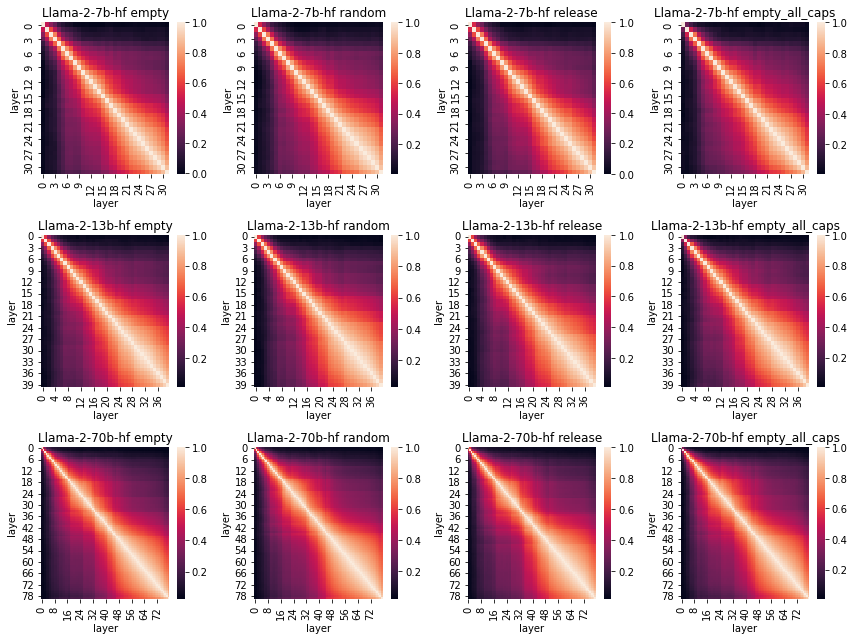

In [9]:
model_directions = make_probe_direction_matrices(models, prompts, experiment_name, entity_type, feature_name)
plot_probe_cosine_sim(model_directions, models, prompts, feature_dim=None)

In [11]:
empty_norm = np.linalg.norm(model_directions[('Llama-2-13b-hf', 'empty')], axis=1)
where_norm = np.linalg.norm(model_directions[('Llama-2-13b-hf', 'empty_all_caps')], axis=1)

In [12]:
# plot norms
plt.plot(empty_norm[:, 0], label='empty_x')
plt.plot(empty_norm[:, 1], label='empty_y')
plt.plot(where_norm[:, 0], label='where_us_x')
plt.plot(where_norm[:, 1], label='where_us_y')
plt.yscale('log')
plt.legend()

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [13]:
dir1 = model_directions[('Llama-2-70b-hf', 'coords')] / np.linalg.norm(model_directions[('Llama-2-70b-hf', 'coords')], axis=1)[:, None]
dir2 = model_directions[('Llama-2-70b-hf', 'where_is')] / np.linalg.norm(model_directions[('Llama-2-70b-hf', 'where_is')], axis=1)[:, None]

KeyError: ('Llama-2-70b-hf', 'coords')

In [72]:
import einops
cos = einops.einsum(dir1, dir2, 'i j k, i j k->i k')

In [85]:
d1 = model_directions[('Llama-2-70b-hf', 'heard')]
d2 = model_directions[('Llama-2-70b-hf', 'release')]

d1_norm = d1 / np.linalg.norm(d1, axis=1, keepdims=True)
d2_norm = d2 / np.linalg.norm(d2, axis=1, keepdims=True)



In [87]:
from sklearn.metrics.pairwise import cosine_similarity
cos = cosine_similarity(d1_norm, d2_norm)

<AxesSubplot:>

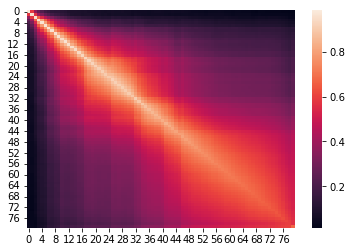

In [89]:
sns.heatmap(cos)

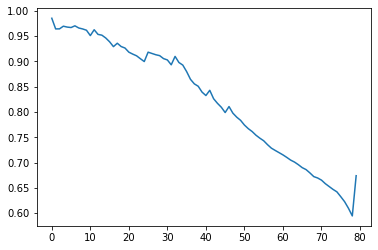

In [91]:
plt.plot(np.diag(cos))

In [14]:
from save_activations import load_activation_probing_dataset

model_name = 'Llama-2-7b-hf'
layer = 20
art_activations_empty = load_activation_probing_dataset(model_name, 'art', 'empty', layer).dequantize()
art_activations_release = load_activation_probing_dataset(model_name, 'art', 'release', layer).dequantize()
art_activations_heard = load_activation_probing_dataset(model_name, 'art', 'heard', layer).dequantize()


In [15]:
print(torch.norm(art_activations_release.mean(axis=0) - art_activations_heard.mean(axis=0)))
print(torch.norm(art_activations_release.mean(axis=0) - art_activations_empty.mean(axis=0)))
print(torch.norm(art_activations_heard.mean(axis=0) - art_activations_empty.mean(axis=0)))

tensor(15.0129)
tensor(18.3742)
tensor(16.5271)


In [16]:
torch.norm(art_activations_release, dim=1).mean(), torch.norm(art_activations_heard, dim=1).mean(), torch.norm(art_activations_empty, dim=1).mean()

(tensor(45.3696), tensor(48.4655), tensor(47.9126))

In [17]:
rel_minus_heard = art_activations_release.mean(axis=0) - art_activations_heard.mean(axis=0)
heard_minus_rel = art_activations_heard.mean(axis=0) - art_activations_release.mean(axis=0)

In [106]:
torch.norm(art_activations_release - rel_minus_heard, dim=1).mean()

tensor(45.6930)

In [116]:
layer, model_name

(20, 'Llama-2-7b-hf')

In [119]:
release_probe_result = load_probe_results(experiment_name, model_name, 'art', 'release_date', 'release')
heard_probe_result = load_probe_results(experiment_name, model_name, 'art', 'release_date', 'heard')

release_art_probe = (release_probe_result['probe_directions'][layer], release_probe_result['probe_biases'][layer])
heard_art_probe = (heard_probe_result['probe_directions'][layer], heard_probe_result['probe_biases'][layer])


In [135]:
release_release_proj = art_activations_release @ release_art_probe[0] + release_art_probe[1]
release_heard_proj = art_activations_release @ heard_art_probe[0] + heard_art_probe[1]
heard_release_proj = art_activations_heard @ release_art_probe[0] + release_art_probe[1]
heard_heard_proj = art_activations_heard @ heard_art_probe[0] + heard_art_probe[1]



(tensor(-0.0015), tensor(-0.0203), tensor(0.0562), tensor(-0.0012))

In [128]:
from probe_experiment import get_target_values
from scipy.stats import pearsonr, spearmanr
target = get_target_values(art_df, 'release_date')

In [134]:
print(spearmanr(release_release_proj, target))
print(spearmanr(release_heard_proj, target))
print(spearmanr(heard_release_proj, target))
print(spearmanr(heard_heard_proj, target))

SignificanceResult(statistic=0.8825221847078611, pvalue=0.0)
SignificanceResult(statistic=0.8688023945977036, pvalue=0.0)
SignificanceResult(statistic=0.8572024769347131, pvalue=0.0)
SignificanceResult(statistic=0.8731354881769028, pvalue=0.0)


In [144]:
spearmanr((art_activations_heard - heard_minus_rel) @ release_art_probe[0] + release_art_probe[1], target)

SignificanceResult(statistic=0.8572024548303668, pvalue=0.0)

In [142]:
np.dot(heard_minus_rel, release_art_probe[0]), np.dot(heard_minus_rel, heard_art_probe[0])

(0.057752848, 0.019124858)

In [146]:
is_test = art_df.is_test.values
train_target = target[~is_test]
test_target = target[is_test]
norm_train_target = (
        train_target - train_target.mean(axis=0)) / train_target.std(axis=0)


In [158]:
score_time_probe((release_release_proj * train_target.std() + train_target.mean())[is_test], target[is_test])

{'mae': 5.46113493744733,
 'mse': 60.23893263024059,
 'rmse': 7.7613744034314305,
 'r2': 0.736329923106472,
 'pearson': 0.887868407792225,
 'pearson_p': 0.0,
 'spearman': 0.8648832107491049,
 'spearman_p': 0.0,
 'kendall': 0.6902374056494975,
 'kendall_p': 0.0}

In [161]:
score_time_probe((release_release_proj * train_target.std() + train_target.mean())[~is_test], target[~is_test])

{'mae': 5.04451723129709,
 'mse': 50.20899347052299,
 'rmse': 7.085830471477778,
 'r2': 0.778792429355391,
 'pearson': 0.9100182193999399,
 'pearson_p': 0.0,
 'spearman': 0.8870635202109681,
 'spearman_p': 0.0,
 'kendall': 0.7179374459958374,
 'kendall_p': 0.0}

In [148]:
score_time_probe(heard_heard_proj * train_target.std() + train_target.mean(), target)

{'mae': 5.403790021884796,
 'mse': 56.59405367340986,
 'rmse': 7.522901944955142,
 'r2': 0.7456458716291734,
 'pearson': 0.8971999440369443,
 'pearson_p': 0.0,
 'spearman': 0.8731354896680699,
 'spearman_p': 0.0,
 'kendall': 0.6980119018831674,
 'kendall_p': 0.0}

In [149]:
score_time_probe(release_heard_proj * train_target.std() + train_target.mean(), target)

{'mae': 5.749920685902401,
 'mse': 61.40569789354373,
 'rmse': 7.836178781366829,
 'r2': 0.6712897461258165,
 'pearson': 0.8923815369686968,
 'pearson_p': 0.0,
 'spearman': 0.8688023976030823,
 'spearman_p': 0.0,
 'kendall': 0.6943023946379119,
 'kendall_p': 0.0}

In [164]:
score_time_probe((((art_activations_release + heard_minus_rel) @ heard_art_probe[0] + heard_art_probe[1]) * train_target.std() + train_target.mean())[is_test], target[is_test])

{'mae': 6.002972901337399,
 'mse': 68.6073091080625,
 'rmse': 8.282952921999648,
 'r2': 0.6353627808670924,
 'pearson': 0.8730255450185647,
 'pearson_p': 0.0,
 'spearman': 0.8510411509287591,
 'spearman_p': 0.0,
 'kendall': 0.6734543288154808,
 'kendall_p': 0.0}

In [165]:
score_time_probe((heard_release_proj * train_target.std() + train_target.mean())[is_test], target[is_test])

{'mae': 6.048012441941466,
 'mse': 70.85385014811814,
 'rmse': 8.417472907477524,
 'r2': 0.6895325521578191,
 'pearson': 0.8678206772698079,
 'pearson_p': 0.0,
 'spearman': 0.842238132264947,
 'spearman_p': 0.0,
 'kendall': 0.6595458126952918,
 'kendall_p': 0.0}

In [156]:
score_time_probe(((art_activations_heard - heard_minus_rel) @ release_art_probe[0] + release_art_probe[1]) * train_target.std() + train_target.mean(), target)

{'mae': 5.790510642234039,
 'mse': 63.90406724975631,
 'rmse': 7.994001954575462,
 'r2': 0.7201010477097964,
 'pearson': 0.8827945243687064,
 'pearson_p': 0.0,
 'spearman': 0.8572024644480714,
 'spearman_p': 0.0,
 'kendall': 0.6763749090281534,
 'kendall_p': 0.0}

In [52]:
import pickle 
models = ['Llama-2-7b-hf', 'Llama-2-13b-hf', 'Llama-2-70b-hf']
layers = [20, 22, 50]
experiment_name = 'full_prompts'
entity_type_names = {'world_place': 'World', 'us_place': 'USA', 'nyc_place': 'NYC', 'art': 'Entertainment', 'headline': 'Headlines', 'historical_figure': 'Historical'}
entity_feature = ['coords', 'coords', 'coords', 'release_date', 'pub_date', 'death_year']
result_dict = {}
for model_name, layer in zip(models, layers):
    for entity_type, feature_name in zip(entity_type_names.keys(), entity_feature):
        path = os.path.join('results', experiment_name, model_name, entity_type, feature_name, 'prompt_gen_eval')
        result = pickle.load(open(os.path.join(path, f'{layer}.p'), 'rb'))
        result_dict[model_name, layer, entity_type_names[entity_type]] = result

In [53]:
flat_result_dict = {(k1 + k2): v2 for k1, v1 in result_dict.items() for k2, v2 in v1.items()}

In [54]:
rdf = pd.DataFrame(flat_result_dict).T
rdf.index.names = ['model', 'layer', 'entity', 'p1', 'p2', 'split', 'prep']
rdf = rdf.reset_index()

In [63]:
rdf.loc[rdf.spearman.isna(), 'spearman']  = rdf.loc[rdf.spearman.isna(), ['x_spearman', 'y_spearman']].mean(axis=1).values
display_cols = ['model', 'layer', 'entity', 'p1', 'p2', 'split', 'prep', 'r2', 'spearman', 'x_spearman', 'y_spearman']

is_same = rdf.p1 == rdf.p2
rdf['test prompt'] = ['same' if x else 'different' for x in is_same]


In [64]:
rdf.loc[(rdf.split == 'test') & (rdf.p1.values == rdf.p2.values)].groupby(['model', 'entity']).r2.mean().unstack().loc[models]

entity,Entertainment,Headlines,Historical,NYC,USA,World
model,,,,,,
Llama-2-7b-hf,0.735693,0.582629,0.749429,0.213122,0.753375,0.819646
Llama-2-13b-hf,0.753064,0.631634,0.770461,0.247881,0.773164,0.843092
Llama-2-70b-hf,0.844600,0.726009,0.807654,0.330829,0.808580,0.870459


In [65]:
rdf.loc[(rdf.split == 'test') & (rdf.p1.values != rdf.p2.values) & (rdf.prep.values == 'centered')].groupby(['model', 'entity']).r2.mean().unstack().loc[models]

entity,Entertainment,Headlines,Historical,NYC,USA,World
model,,,,,,
Llama-2-7b-hf,0.705185,0.070832,0.690981,0.111809,0.591463,0.785905
Llama-2-13b-hf,0.726483,0.518172,0.724862,0.160354,0.655889,0.812561
Llama-2-70b-hf,0.814338,0.616321,0.756613,0.223149,0.671530,0.836775


In [66]:
rdf.loc[(rdf.split == 'test') & (rdf.p1.values == rdf.p2.values)].groupby(['model', 'entity']).spearman.mean().unstack().loc[models]

entity,Entertainment,Headlines,Historical,NYC,USA,World
model,,,,,,
Llama-2-7b-hf,0.826198,0.772069,0.864911,0.447284,0.857728,0.898530
Llama-2-13b-hf,0.836244,0.798916,0.880065,0.487013,0.870285,0.910412
Llama-2-70b-hf,0.897174,0.855729,0.903643,0.564118,0.889935,0.924243


In [67]:
rdf.loc[(rdf.split == 'test') & (rdf.p1.values != rdf.p2.values) & (rdf.prep.values == 'centered')].groupby(['model', 'entity']).spearman.mean().unstack().loc[models]

entity,Entertainment,Headlines,Historical,NYC,USA,World
model,,,,,,
Llama-2-7b-hf,0.807989,0.562239,0.825885,0.362018,0.772641,0.879448
Llama-2-13b-hf,0.820140,0.738687,0.853946,0.415440,0.808944,0.894165
Llama-2-70b-hf,0.882596,0.820073,0.876125,0.494611,0.824228,0.906693


In [68]:
rdf.loc[(rdf.split == 'test') & (rdf.p1.values != rdf.p2.values) & (rdf.prep.values == 'centered')].groupby(['model', 'entity']).spearman.mean().unstack().loc[models]

entity,Entertainment,Headlines,Historical,NYC,USA,World
model,,,,,,
Llama-2-7b-hf,0.807989,0.562239,0.825885,0.362018,0.772641,0.879448
Llama-2-13b-hf,0.820140,0.738687,0.853946,0.415440,0.808944,0.894165
Llama-2-70b-hf,0.882596,0.820073,0.876125,0.494611,0.824228,0.906693


In [75]:
col_order = ['World', 'USA', 'NYC', 'Historical', 'Entertainment', 'Headlines']

prompt_table_spearman = rdf.loc[rdf.split == 'test'].groupby(['model', 'test prompt', 'entity']).spearman.mean().unstack().loc[
    [(model, split) for model in models for split in ['same', 'different']], col_order
].round(3)
prompt_table_spearman

entity                      World    USA    NYC  Historical  Entertainment  \
model          test prompt                                                   
Llama-2-7b-hf  same         0.899  0.858  0.447       0.865          0.826   
               different    0.879  0.773  0.362       0.826          0.808   
Llama-2-13b-hf same         0.910  0.870  0.487       0.880          0.836   
               different    0.894  0.809  0.415       0.854          0.820   
Llama-2-70b-hf same         0.924  0.890  0.564       0.904          0.897   
               different    0.907  0.824  0.495       0.876          0.883   

entity                      Headlines  
model          test prompt             
Llama-2-7b-hf  same             0.772  
               different        0.562  
Llama-2-13b-hf same             0.799  
               different        0.739  
Llama-2-70b-hf same             0.856  
               different        0.820

In [77]:
print(prompt_table_spearman.to_latex(float_format="{:0.3f}".format))

\begin{tabular}{llrrrrrr}
\toprule
 & entity & World & USA & NYC & Historical & Entertainment & Headlines \\
model & test prompt &  &  &  &  &  &  \\
\midrule
\multirow[t]{2}{*}{Llama-2-7b-hf} & same & 0.899 & 0.858 & 0.447 & 0.865 & 0.826 & 0.772 \\
 & different & 0.879 & 0.773 & 0.362 & 0.826 & 0.808 & 0.562 \\
\cline{1-8}
\multirow[t]{2}{*}{Llama-2-13b-hf} & same & 0.910 & 0.870 & 0.487 & 0.880 & 0.836 & 0.799 \\
 & different & 0.894 & 0.809 & 0.415 & 0.854 & 0.820 & 0.739 \\
\cline{1-8}
\multirow[t]{2}{*}{Llama-2-70b-hf} & same & 0.924 & 0.890 & 0.564 & 0.904 & 0.897 & 0.856 \\
 & different & 0.907 & 0.824 & 0.495 & 0.876 & 0.883 & 0.820 \\
\cline{1-8}
\bottomrule
\end{tabular}



In [76]:
prompt_table_r2 = rdf.loc[rdf.split == 'test'].groupby(['model', 'test prompt', 'entity']).r2.mean().unstack().loc[
    [(model, split) for model in models for split in ['same', 'different']], col_order
].round(3)
prompt_table_r2

entity                      World    USA    NYC  Historical  Entertainment  \
model          test prompt                                                   
Llama-2-7b-hf  same         0.820  0.753  0.213       0.749          0.736   
               different    0.781  0.573  0.073       0.673          0.697   
Llama-2-13b-hf same         0.843  0.773  0.248       0.770          0.753   
               different    0.810  0.647  0.122       0.709          0.724   
Llama-2-70b-hf same         0.870  0.809  0.331       0.808          0.845   
               different    0.836  0.661  0.203       0.741          0.813   

entity                      Headlines  
model          test prompt             
Llama-2-7b-hf  same             0.583  
               different       -0.271  
Llama-2-13b-hf same             0.632  
               different        0.505  
Llama-2-70b-hf same             0.726  
               different        0.608

In [79]:
print(prompt_table_r2.to_latex(float_format="{:0.3f}".format))

\begin{tabular}{llrrrrrr}
\toprule
 & entity & World & USA & NYC & Historical & Entertainment & Headlines \\
model & test prompt &  &  &  &  &  &  \\
\midrule
\multirow[t]{2}{*}{Llama-2-7b-hf} & same & 0.820 & 0.753 & 0.213 & 0.749 & 0.736 & 0.583 \\
 & different & 0.781 & 0.573 & 0.073 & 0.673 & 0.697 & -0.271 \\
\cline{1-8}
\multirow[t]{2}{*}{Llama-2-13b-hf} & same & 0.843 & 0.773 & 0.248 & 0.770 & 0.753 & 0.632 \\
 & different & 0.810 & 0.647 & 0.122 & 0.709 & 0.724 & 0.505 \\
\cline{1-8}
\multirow[t]{2}{*}{Llama-2-70b-hf} & same & 0.870 & 0.809 & 0.331 & 0.808 & 0.845 & 0.726 \\
 & different & 0.836 & 0.661 & 0.203 & 0.741 & 0.813 & 0.608 \\
\cline{1-8}
\bottomrule
\end{tabular}



In [35]:
# display 100 rows
pd.set_option('display.max_rows', 100)
rdf.loc[(rdf.split == 'test') & (rdf.p1.values != rdf.p2.values) & (rdf.prep.values == 'centered')].query('model == "Llama-2-70b-hf"')[display_cols]#.groupby(['model', 'entity']).r2.mean().unstack().loc[models]

,model,layer,entity,p1,p2,split,prep,r2,spearman,x_spearman,y_spearman
775,Llama-2-70b-hf,50,world_place,empty,empty_all_caps,test,centered,0.885204,0.935221,0.940046,0.930397
779,Llama-2-70b-hf,50,world_place,empty,random,test,centered,0.880082,0.921575,0.929095,0.914054
783,Llama-2-70b-hf,50,world_place,empty,coords,test,centered,0.869708,0.925315,0.921747,0.928883
787,Llama-2-70b-hf,50,world_place,empty_all_caps,empty,test,centered,0.833317,0.914886,0.917168,0.912604
795,Llama-2-70b-hf,50,world_place,empty_all_caps,random,test,centered,0.823675,0.895010,0.904663,0.885357
799,Llama-2-70b-hf,50,world_place,empty_all_caps,coords,test,centered,0.799232,0.895693,0.896525,0.894861
803,Llama-2-70b-hf,50,world_place,random,empty,test,centered,0.776230,0.881950,0.886169,0.877731
807,Llama-2-70b-hf,50,world_place,random,empty_all_caps,test,centered,0.783502,0.876699,0.888380,0.865018
815,Llama-2-70b-hf,50,world_place,random,coords,test,centered,0.752842,0.860166,0.865787,0.854545
819,Llama-2-70b-hf,50,world_place,coords,empty,test,centered,0.884611,0.933197,0.936032,0.930362


In [23]:
rdf.loc[(rdf.split == 'test') & (rdf.p1.values != rdf.p2.values) & (rdf.prep.values == 'uncentered')].groupby(['model', 'entity']).r2.mean().unstack().loc[models]

entity,art,headline,historical_figure,nyc_place,us_place,world_place
model,,,,,,
Llama-2-7b-hf,0.688720,-0.611956,0.655911,0.033303,0.554378,0.776128
Llama-2-13b-hf,0.721763,0.492613,0.693814,0.082957,0.638845,0.807570
Llama-2-70b-hf,0.812455,0.600439,0.724785,0.183045,0.650353,0.835195


In [191]:
rdf.loc[(rdf.split == 'test') & (rdf.p1.values == rdf.p2.values)].groupby(['model', 'entity']).r2.mean().unstack().loc[models]

entity,art,headline,historical_figure,nyc_place,us_place,world_place
model,,,,,,
Llama-2-7b-hf,0.839401,0.454992,0.882831,NaN,NaN,NaN
Llama-2-13b-hf,0.846922,0.744140,0.895004,NaN,NaN,NaN
Llama-2-70b-hf,0.894171,0.781449,0.900785,NaN,NaN,NaN


In [192]:
rdf.loc[(rdf.split == 'test') & (rdf.p1.values != rdf.p2.values) & (rdf.prep.values == 'centered')].groupby(['model', 'entity'])['spearman'].mean().unstack().loc[models]

entity,art,headline,historical_figure,nyc_place,us_place,world_place
model,,,,,,
Llama-2-7b-hf,0.839401,0.454992,0.882831,NaN,NaN,NaN
Llama-2-13b-hf,0.846922,0.744140,0.895004,NaN,NaN,NaN
Llama-2-70b-hf,0.894171,0.781449,0.900785,NaN,NaN,NaN


In [193]:
rdf.loc[(rdf.split == 'test') & (rdf.p1.values == rdf.p2.values)].groupby(['model', 'entity'])['spearman'].mean().unstack().loc[models]

entity,art,headline,historical_figure,nyc_place,us_place,world_place
model,,,,,,
Llama-2-7b-hf,0.853148,0.776443,0.897312,NaN,NaN,NaN
Llama-2-13b-hf,0.860899,0.803137,0.909744,NaN,NaN,NaN
Llama-2-70b-hf,0.909484,0.856344,0.921077,NaN,NaN,NaN


In [195]:
rdf.loc[(rdf.split == 'test') & (rdf.p1.values == rdf.p2.values)].groupby(['model', 'entity'])['x_spearman'].mean().unstack().loc[models]

entity,art,headline,historical_figure,nyc_place,us_place,world_place
model,,,,,,
Llama-2-7b-hf,NaN,NaN,NaN,0.415124,0.885336,0.928542
Llama-2-13b-hf,NaN,NaN,NaN,0.435431,0.892108,0.932390
Llama-2-70b-hf,NaN,NaN,NaN,0.532878,0.909438,0.944664


In [202]:
rdf.loc[(rdf.split == 'test') & (rdf.p1.values == rdf.p2.values) & (rdf.prep == 'centered')]

,model,layer,entity,p1,p2,split,prep,x_r2,y_r2,r2,...,haversine_mse,haversine_rmse,haversine_mae,haversine_r2,pearson,pearson_p,spearman,spearman_p,kendall,kendall_p
3,Llama-2-7b-hf,20,world_place,empty,empty,test,centered,0.873682,0.870356,0.872019,...,8.495113e+06,2914.637727,1689.299973,0.879430,NaN,NaN,NaN,NaN,NaN,NaN
23,Llama-2-7b-hf,20,world_place,describe,describe,test,centered,0.866289,0.866715,0.866502,...,8.998972e+06,2999.828651,1789.263525,0.872278,NaN,NaN,NaN,NaN,NaN,NaN
43,Llama-2-7b-hf,20,world_place,where_is,where_is,test,centered,0.871970,0.877372,0.874671,...,8.547357e+06,2923.586381,1720.254994,0.878688,NaN,NaN,NaN,NaN,NaN,NaN
63,Llama-2-7b-hf,20,world_place,coords,coords,test,centered,0.879717,0.890097,0.884907,...,7.851871e+06,2802.119017,1585.252714,0.888559,NaN,NaN,NaN,NaN,NaN,NaN
67,Llama-2-7b-hf,20,us_place,empty,empty,test,centered,0.816982,0.757924,0.787453,...,5.205878e+05,721.517691,428.110968,0.816116,NaN,NaN,NaN,NaN,NaN,NaN
79,Llama-2-7b-hf,20,us_place,where_us,where_us,test,centered,0.804471,0.755187,0.779829,...,5.560402e+05,745.681007,461.698714,0.803593,NaN,NaN,NaN,NaN,NaN,NaN
83,Llama-2-7b-hf,20,nyc_place,where_is,where_is,test,centered,0.153043,0.165851,0.159447,...,7.733042e+01,8.793771,6.751294,0.153966,NaN,NaN,NaN,NaN,NaN,NaN
99,Llama-2-7b-hf,20,nyc_place,where_nyc,where_nyc,test,centered,0.159101,0.178100,0.168601,...,7.673423e+01,8.759808,6.707114,0.160488,NaN,NaN,NaN,NaN,NaN,NaN
115,Llama-2-7b-hf,20,nyc_place,where_nyc_normalized,where_nyc_normalized,test,centered,0.194963,0.249437,0.222200,...,7.321524e+01,8.556591,6.514282,0.198988,NaN,NaN,NaN,NaN,NaN,NaN
119,Llama-2-7b-hf,20,art,empty,empty,test,centered,NaN,NaN,0.768966,...,NaN,NaN,NaN,NaN,0.876960,0.0,0.842786,0.0,0.664151,0.0


In [203]:
pd.set_option('display.max_rows', 150)
display_cols = ['model', 'layer', 'entity', 'p1', 'p2', 'split', 'prep', 'r2', 'spearman', 'x_spearman', 'y_spearman']
rdf.loc[(rdf.split == 'test') & (rdf.p1.values != rdf.p2.values) & (rdf.prep == 'centered')][display_cols]

,model,layer,entity,p1,p2,split,prep,r2,spearman,x_spearman,y_spearman
7,Llama-2-7b-hf,20,world_place,empty,describe,test,centered,0.844339,NaN,0.913258,0.904626
11,Llama-2-7b-hf,20,world_place,empty,where_is,test,centered,0.828115,NaN,0.897562,0.887435
15,Llama-2-7b-hf,20,world_place,empty,coords,test,centered,0.844276,NaN,0.915953,0.914909
19,Llama-2-7b-hf,20,world_place,describe,empty,test,centered,0.795288,NaN,0.910229,0.907678
27,Llama-2-7b-hf,20,world_place,describe,where_is,test,centered,0.798870,NaN,0.896752,0.872435
31,Llama-2-7b-hf,20,world_place,describe,coords,test,centered,0.798503,NaN,0.903888,0.909786
35,Llama-2-7b-hf,20,world_place,where_is,empty,test,centered,0.781194,NaN,0.907305,0.894238
39,Llama-2-7b-hf,20,world_place,where_is,describe,test,centered,0.811429,NaN,0.903659,0.899116
47,Llama-2-7b-hf,20,world_place,where_is,coords,test,centered,0.813620,NaN,0.909066,0.911537
51,Llama-2-7b-hf,20,world_place,coords,empty,test,centered,0.850410,NaN,0.919481,0.910505


In [207]:
rdf.loc[rdf.spearman.isna(), 'spearman']  = rdf.loc[rdf.spearman.isna(), ['x_spearman', 'y_spearman']].mean(axis=1).values

In [209]:
rdf['is_same'] = rdf.p1 == rdf.p2

In [215]:
rdf.query('split == "test" and prep == "centered"').groupby(['model', 'entity', 'is_same']).spearman.mean().unstack(level=1).loc[models]

entity                       art  headline  historical_figure  nyc_place  \
model          is_same                                                     
Llama-2-7b-hf  False    0.839401  0.454992           0.882831   0.344144   
               True     0.853148  0.776443           0.897312   0.428152   
Llama-2-13b-hf False    0.846922  0.744140           0.895004   0.378158   
               True     0.860899  0.803137           0.909744   0.459466   
Llama-2-70b-hf False    0.894171  0.781449           0.900785   0.493765   
               True     0.909484  0.856344           0.921077   0.561981   

entity                  us_place  world_place  
model          is_same                         
Llama-2-7b-hf  False    0.780420     0.906002  
               True     0.874502     0.928580  
Llama-2-13b-hf False    0.835192     0.913725  
               True     0.888008     0.932786  
Llama-2-70b-hf False    0.836222     0.920860  
               True     0.908691     0.943056

In [216]:
rdf.query('split == "test" and prep == "centered"').groupby(['model', 'entity', 'is_same']).r2.mean().unstack(level=1).loc[models]

entity                       art  headline  historical_figure  nyc_place  \
model          is_same                                                     
Llama-2-7b-hf  False    0.749177 -0.170909           0.770775   0.088519   
               True     0.774539  0.590817           0.797036   0.183416   
Llama-2-13b-hf False    0.765965  0.542189           0.781839   0.117114   
               True     0.790197  0.638162           0.810877   0.213606   
Llama-2-70b-hf False    0.826609  0.578565           0.749897   0.240604   
               True     0.862113  0.728667           0.834333   0.325933   

entity                  us_place  world_place  
model          is_same                         
Llama-2-7b-hf  False    0.592588     0.824100  
               True     0.783641     0.874525  
Llama-2-13b-hf False    0.676197     0.841078  
               True     0.807594     0.886242  
Llama-2-70b-hf False    0.695833     0.839832  
               True     0.841768     0.908276

In [196]:
rdf.loc[(rdf.split == 'test') & (rdf.p1.values != rdf.p2.values) & (rdf.prep.values == 'centered')].groupby(['model', 'entity'])['x_spearman'].mean().unstack().loc[models]

entity,art,headline,historical_figure,nyc_place,us_place,world_place
model,,,,,,
Llama-2-7b-hf,NaN,NaN,NaN,0.325604,0.828628,0.909144
Llama-2-13b-hf,NaN,NaN,NaN,0.344311,0.851378,0.916147
Llama-2-70b-hf,NaN,NaN,NaN,0.464626,0.828623,0.921219


In [197]:
rdf.loc[(rdf.split == 'test') & (rdf.p1.values == rdf.p2.values)].groupby(['model', 'entity'])['y_spearman'].mean().unstack().loc[models]

entity,art,headline,historical_figure,nyc_place,us_place,world_place
model,,,,,,
Llama-2-7b-hf,NaN,NaN,NaN,0.441181,0.863668,0.928618
Llama-2-13b-hf,NaN,NaN,NaN,0.483501,0.883908,0.933181
Llama-2-70b-hf,NaN,NaN,NaN,0.591084,0.907945,0.941448


In [198]:
rdf.loc[(rdf.split == 'test') & (rdf.p1.values != rdf.p2.values) & (rdf.prep.values == 'centered')].groupby(['model', 'entity'])['y_spearman'].mean().unstack().loc[models]

entity,art,headline,historical_figure,nyc_place,us_place,world_place
model,,,,,,
Llama-2-7b-hf,NaN,NaN,NaN,0.362684,0.732212,0.902861
Llama-2-13b-hf,NaN,NaN,NaN,0.412005,0.819006,0.911302
Llama-2-70b-hf,NaN,NaN,NaN,0.522904,0.843822,0.920501


In [176]:
rdf.query('split == "test"').groupby(['model', 'entity', 'prep']).mean()

x_r2      y_r2        r2  \
model          entity            prep                                       
Llama-2-13b-hf art               centered         NaN       NaN  0.774042   
                                 uncentered       NaN       NaN  0.771213   
               headline          centered         NaN       NaN  0.590176   
                                 uncentered       NaN       NaN  0.589583   
               historical_figure centered         NaN       NaN  0.791518   
                                 uncentered       NaN       NaN  0.784121   
               nyc_place         centered    0.109096  0.189460  0.149278   
                                 uncentered  0.032024  0.141649  0.086836   
               us_place          centered    0.772156  0.711635  0.741896   
                                 uncentered  0.757403  0.697502  0.727453   
               world_place       centered    0.845431  0.859307  0.852369   
                                 uncentered  0.839578  0.838713  0.839146   
Llama-2-70b-hf art               centered         NaN       NaN  0.838444   
                                 uncentered       NaN       NaN  0.835404   
               headline          centered         NaN       NaN  0.653616   
                                 uncentered       NaN       NaN  0.640262   
               historical_figure centered         NaN       NaN  0.778043   
                                 uncentered       NaN       NaN  0.762278   
               nyc_place         centered    0.241484  0.296610  0.269047   
                                 uncentered  0.201178  0.267381  0.234279   
               us_place          centered    0.779785  0.757816  0.768801   
                                 uncentered  0.759272  0.742879  0.751076   
               world_place       centered    0.846828  0.867058  0.856943   
                                 uncentered  0.832902  0.857997  0.845449   
Llama-2-7b-hf  art               centered         NaN       NaN  0.757631   
                                 uncentered       NaN       NaN  0.750643   
               headline          centered         NaN       NaN  0.209954   
                                 uncentered       NaN       NaN -0.345014   
               historical_figure centered         NaN       NaN  0.779529   
                                 uncentered       NaN       NaN  0.766688   
               nyc_place         centered    0.092654  0.147648  0.120151   
                                 uncentered  0.079858  0.131137  0.105498   
               us_place          centered    0.738428  0.637801  0.688114   
                                 uncentered  0.719125  0.600076  0.659601   
               world_place       centered    0.831895  0.841517  0.836706   
                                 uncentered  0.776190  0.837959  0.807074   

                                                 x_mae     y_mae         mae  \
model          entity            prep                                          
Llama-2-13b-hf art               centered          NaN       NaN    5.754830   
                                 uncentered        NaN       NaN    5.808987   
               headline          centered          NaN       NaN    1.531161   
                                 uncentered        NaN       NaN    1.532191   
               historical_figure centered          NaN       NaN  140.831296   
                                 uncentered        NaN       NaN  144.932956   
               nyc_place         centered     0.056938  0.061609    0.059274   
                                 uncentered   0.059958  0.063141    0.061549   
               us_place          centered     4.796507  1.909061    3.352784   
                                 uncentered   5.121227  1.987634    3.554430   
               world_place       centered    19.070704  6.691740   12.881222   
                                 uncentered  19.605142  7.454980   13.530061   
Ll

In [261]:
us_df.name.values[::200]

array(['New York', 'Kalamazoo', 'Daly City', 'Tamarac', 'Pinellas Park',
       'Chelsea', 'American Fork', 'Hutto', 'Copiague', 'Hanahan',
       'Willimantic', 'Americus', 'Palmer Ranch', 'Beaufort',
       'Port Lavaca', 'Magalia', 'Sweet Home', 'North Haledon',
       'Iowa Colony', 'Tell City', 'Manorhaven', 'Chesapeake Beach',
       'DeFuniak Springs', 'Williamsville', 'Wilmer', 'Lake Worth',
       'Bloomfield Hills', 'Hawkinsville', 'Coal Valley', 'Ballinger',
       'Marienville', 'Zillah', 'Annetta', 'Essex Village', 'Arcanum',
       'Piperton', 'Henry', 'Hurlock', 'Bethel Island',
       'Shinnecock Hills', 'Farmer City', 'Old Brookville', 'Queens Gate',
       'Uhland', 'Ruhenstroth', 'Kilmarnock', 'Falkville', 'Navesink',
       'Snead', 'Merryville', 'Hargill', 'Santa Ana Pueblo', 'Hymera',
       'Wagram', 'Green Lake', 'Beckville', 'Exira', 'Harwood',
       'Columbiaville', 'Kosse', 'Boissevain', 'Eulonia', 'Atlantic Mine',
       'Pownal Center', 'Beverly Beach', '0

In [224]:
world_df['has_comma'] = world_df.name.str.contains(',')

In [262]:
world_df.query('has_comma').name.values[2::100]

array(['Landmark Theatre (Syracuse, New York)',
       'Saenger Theatre (Pensacola, Florida)',
       'St Mary of the Angels, Wellington', 'Santi Michele e Magno, Rome',
       'St. Thomas Cathedral, Mumbai',
       'St. Francis Xavier Church (Cincinnati, Ohio)',
       'St John the Baptist Church (Taytay, Rizal)',
       'Cathedral of St. Matthew the Apostle (Washington, D.C.)',
       'Trident Hotel, Nariman Point', 'Fairfield House, Bath',
       'Government Arts College, Ooty', 'Kaya, Burkina Faso',
       'Tillman County, Oklahoma', 'Lake Cargelligo, New South Wales',
       'Hamilton County, Ohio', 'Panton Hill, Victoria',
       'Harrisville, Queensland', 'Rawson, Victoria',
       'Washington County, Texas', 'Nome Census Area, Alaska',
       'Yarck, Victoria', 'Dirranbandi, Queensland',
       'Ilfracombe, Queensland', 'Comas District, Lima',
       'Decatur County, Tennessee', 'Bowie County, Texas',
       'Cressy, Tasmania', 'Cherry County, Nebraska',
       'Pottsville, New

In [246]:
world_df.query('not has_comma').name.values[2::100]

array(['Ford Rotunda', 'Pochayiv Lavra', 'Belmond Hotel Cipriani',
       'Bled Castle', 'Barrow Street Theatre', 'North–South Motorway',
       'The Masque (venue)', 'Teatro Bibiena',
       'Bruce Nuclear Generating Station', 'Whitelee Wind Farm',
       'Mühleberg Nuclear Power Plant', 'Kuosheng Nuclear Power Plant',
       'Hanul Nuclear Power Plant', 'Bow Road tube station',
       'Beckenham Hill railway station', 'Haydons Road railway station',
       'South Kentish Town tube station', 'Banstead railway station',
       'Lee railway station', 'West Brompton station',
       'Monticello Reservoir', 'Conchas Lake', 'Watson Lake (Arizona)',
       'Madden Dam', 'Zhinvali Dam', 'Maroondah Dam', 'Big Stone Lake',
       'Lake Diefenbaker', 'Kamalasagar', 'Church of St Joan of Arc',
       'Basilica of the National Shrine of the Assumption of the Blessed Virgin Mary',
       'Catedral Metropolitana Ortodoxa', 'Christ the King (Almada)',
       'Coventry Cathedral',
       'National Sh

In [233]:
world_df.groupby('country').has_comma.sum().sort_values(ascending=False).head(20)

country
United_States               4768
Australia                   2178
United_Kingdom               818
India                        439
Canada                       414
Japan                        281
England                      175
Italy                        145
South_Africa                 125
United_States_of_America      98
Syria                         94
Mexico                        93
Argentina                     84
Brazil                        81
Colombia                      66
Chile                         58
Puerto_Rico                   49
China                         48
Republic_of_Ireland           46
Poland                        42
Name: has_comma, dtype: int64

In [234]:
world_df.groupby('country').has_comma.count().sort_values(ascending=False).head(20)

country
United_States     6324
United_Kingdom    4096
India             3685
Australia         3373
Italy             1761
Canada            1116
South_Africa       748
England            567
Syria              534
Japan              533
Poland             460
China              443
Philippines        402
Brazil             398
Mexico             379
Sweden             346
Indonesia          335
Switzerland        312
Pakistan           304
Netherlands        273
Name: has_comma, dtype: int64

In [240]:
world_probe_result['projections'][55]

,x,y,is_test,x_error,y_error,prox_error
0,-21.119803,-5.103891,False,26.740497,10.697809,0.041379
1,91.327547,9.488555,False,10.627847,2.051615,0.089504
2,-81.177649,32.348506,False,1.999051,-9.963594,0.026172
3,28.793552,56.013851,False,23.626882,3.013851,0.289605
4,63.924164,26.588906,True,28.197064,-7.211894,0.196741
...,...,...,...,...,...,...
39580,-128.432648,45.948952,False,-22.607648,5.475652,0.133586
39581,-125.241961,52.149023,True,-4.764961,1.666023,0.002476
39582,64.060388,57.384076,True,-44.939612,-16.365924,0.202880
39583,98.117319,0.523100,True,-10.549681,2.606430,0.022913


In [241]:
world_df['prox_error'] = world_probe_result['projections'][55].prox_error.values

In [244]:
world_df.query('is_test').groupby('has_comma').prox_error.mean()

has_comma
False    0.090619
True     0.043084
Name: prox_error, dtype: float64

In [245]:
world_df.groupby('entity_type').has_comma.mean()

entity_type
natural_place      0.010643
populated_place    0.346263
structure          0.157136
Name: has_comma, dtype: float64

In [251]:
world_df.groupby('country').entity_type.value_counts().unstack().sort_values('populated_place', ascending=False).head(20)

entity_type,natural_place,populated_place,structure
country,,,
United_States,490.0,4771.0,1063.0
India,99.0,3225.0,361.0
United_Kingdom,13.0,3093.0,990.0
Australia,83.0,3010.0,280.0
Italy,42.0,1518.0,201.0
Canada,258.0,721.0,137.0
South_Africa,24.0,651.0,73.0
Syria,NaN,516.0,18.0
Japan,56.0,423.0,54.0


In [256]:
world_df.groupby('country').entity_subtype.value_counts().unstack().sort_values('Station', ascending=False).head(20)

entity_subtype,Airport,AmusementParkAttraction,ArchitecturalStructure,Bay,BodyOfWater,Bridge,Building,Castle,Cave,Cinema,...,RoadJunction,Sea,ShoppingMall,SkiArea,Stadium,Station,Stream,Theatre,Venue,Volcano
country,,,,,,,,,,,,,,,,,,,,,
United_Kingdom,3.0,NaN,2.0,NaN,1.0,NaN,91.0,1.0,NaN,NaN,...,3.0,1.0,NaN,NaN,1.0,680.0,1.0,9.0,12.0,1.0
New_Zealand,NaN,NaN,1.0,NaN,25.0,NaN,9.0,NaN,NaN,NaN,...,NaN,1.0,NaN,NaN,1.0,3.0,NaN,1.0,2.0,NaN
England,2.0,NaN,1.0,NaN,2.0,NaN,234.0,4.0,NaN,1.0,...,NaN,NaN,NaN,NaN,2.0,3.0,3.0,5.0,35.0,NaN
Japan,NaN,NaN,NaN,NaN,15.0,NaN,25.0,NaN,NaN,NaN,...,NaN,1.0,NaN,NaN,NaN,2.0,NaN,2.0,4.0,1.0
Uganda,NaN,NaN,1.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN
Canada,NaN,NaN,13.0,2.0,30.0,NaN,55.0,NaN,NaN,1.0,...,NaN,2.0,NaN,NaN,2.0,2.0,NaN,NaN,4.0,4.0
Wales,NaN,NaN,NaN,NaN,1.0,NaN,26.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,3.0,NaN
Hong_Kong,NaN,NaN,NaN,NaN,NaN,NaN,24.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN
India,NaN,NaN,19.0,NaN,26.0,NaN,104.0,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,5.0,1.0,2.0,NaN,7.0,NaN


In [254]:
world_df.entity_subtype.value_counts()

entity_subtype
PopulatedPlace                      22125
Region                               7365
Building                             1869
HistoricBuilding                     1556
Island                               1273
Lake                                 1119
Dam                                   870
Station                               709
PowerStation                          473
BodyOfWater                           415
Mountain                              350
Venue                                 319
MountainRange                         240
Road                                  113
Theatre                               104
ArchitecturalStructure                 81
Castle                                 75
Sea                                    69
Hotel                                  64
Stadium                                57
Volcano                                52
River                                  46
Museum                                 37
Cinema             

In [258]:
world_df.query('is_test').groupby('entity_subtype').prox_error.mean().sort_values()

entity_subtype
ShoppingMall                        0.023965
RoadJunction                        0.046103
NaturalPlace                        0.047149
Region                              0.047786
MilitaryStructure                   0.056654
Station                             0.064552
PopulatedPlace                      0.066580
GovernmentalAdministrativeRegion    0.076443
Airport                             0.076481
Stadium                             0.080028
Dam                                 0.084278
MountainRange                       0.089476
Castle                              0.089537
Road                                0.092398
Mountain                            0.099110
Theatre                             0.100417
Venue                               0.104008
PowerStation                        0.104056
Sea                                 0.105319
Lake                                0.106054
HistoricBuilding                    0.108377
River                               0.11

In [265]:
names = world_df.name.values

In [266]:
names

array(['Tancredo Neves Pantheon of the Fatherland and Freedom',
       'Sembuwatta Lake', 'Ford Rotunda', ..., 'Khatanga Gulf',
       'Karimata Strait', 'Kawagama Lake'], dtype=object)

In [273]:
decomma_names = []
normed_name = []
for name in names:
    if ',' in name:
        decomma_names.append(','.join(name.split(',')[:-1]))
    else:
        decomma_names.append(name)

    name, processed = move_text_within_parentheses(name)

    if not processed and ',' in name:
        splits = name.split(',')
        name = f"{splits[-1].strip()}'s {','.join(splits[:-1])}"

    normed_name.append(name)

In [274]:
world_df['decomma'] = decomma_names
world_df['normed_name'] = normed_name

World (all normalized)
- empty
- random
- coords
- ALL CAPS

USA
- empty
- random
- coords
- where_us

NYC Map
- empty
- random
- where
- where_nyc

Historical figures
- empty
- random
- death date
- ALL CAPS

Entertainment
- empty
- random
- release date
- ALL CAPS

Headlines
- empty (period)
- empty
- when
- when (period)

In [5]:
token_ids = torch.tensor([[10, 1000, 10], [1, 2, 3]])

In [9]:
torch.randint(low=100, high=token_ids.max().item(), size=(5, 10), dtype=torch.long)

torch.int64

In [80]:
t = load_tokenized_dataset('historical_figure', 'when_all_caps', 'Llama-2')

In [81]:
tokenizer.decode(t['input_ids'][50])#[torch.where(row)[0]])

'<s> When did WILLIAM SHAKESPEARE</s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s>'

In [72]:
# get the last nonzero element of row
row =torch.tensor(t['entity_mask'][50])
torch.where(row)[0]


tensor([ 7,  8,  9, 10, 11, 12, 13, 14, 15, 16])

In [13]:
from transformers import AutoTokenizer, AutoModelForCausalLM
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-hf")


In [272]:
import re

def move_text_within_parentheses(input_str):
    # Find text within parentheses using regular expression
    match = re.search(r'\((.*?)\)', input_str)
    
    # Check if there's any text within parentheses
    if match:
        text_within_parentheses = match.group(1)
        
        # Remove text within parentheses from the original string
        input_str = re.sub(r'\((.*?)\)', '', input_str)
        
        # Prepend the text followed by a 's' and the rest of the string
        output_str = f"{text_within_parentheses}'s {input_str}"
        
        return output_str, True
    
    return input_str, False

# Test the function
print(move_text_within_parentheses("Hello (world)!"))  # Output should be "world's Hello !"
print(move_text_within_parentheses("No parentheses here!"))  # Output should be "No parentheses here!"

("world's Hello !", True)
('No parentheses here!', False)
